# Deep Learning Adder & Subtractor

## Overview of this notebook

This notebook presents: 

* detailed code of data genetators and model trainers for each model

* simple usage of creating models using these functions

### 1. Utilities

### 2. Adder
        
   * Data Generator
   * Model Trainer
   * Training and Testing (Trained a 5-digit adder)
    
### 3. Subtractor
    
   * Data Generator
   * Model Trainer
   * Training and Testing (Trained a 4-digit subtractor)
    
### 4. Adder and Subtractor Combined
    
   * Data Generator
   * Model Trainer
   * Training and Testing (Trained a 5-digit adder&subtractor)
   

All Utilities are in **utils.py**

All Data Generators are in **data_generators.py**

All Model Trainers are in **model_trainers.py**

In [1]:
from keras.models import Sequential
from keras import layers
from keras.models import load_model
import numpy as np
from six.moves import range

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## 1. Utilities

Used to present colors in testing result

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

Used to create ont-hot vector encoder-decoder

In [3]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

Used to test model accuracy on test data

In [4]:
def model_tester(model, test_x, test_y, ctable):
    
    print('Testing...')
    
    REVERSE = False
    for i in range(10):
        ind = np.random.randint(0, len(test_x))
        rowx, rowy = test_x[np.array([ind])], test_y[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
    
    print()
    print('Test Accuracy on '+ str(len(test_x)) +' test data: ', model.evaluate(test_x, test_y, verbose=False)[1])

## 2. Adder

### Data Generator

In [5]:
def generate_addition_data(train_size, digits, ctable, chars):
    
    data_size = train_size + 2000 + 40000
    maxlen = digits + 1 + digits
    questions = []
    expected = []
    seen = set()
    print('Generating data...')
    while len(questions) < data_size:
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, digits + 1))))
        a, b = f(), f()
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)
        q = '{}+{}'.format(a, b)
        query = q + ' ' * (maxlen - len(q))
        ans = str(a + b)
        ans += ' ' * (digits + 1 - len(ans))
        questions.append(query)
        expected.append(ans)

    print('Total addition questions:', len(questions))
    print('Example questions:')
    print(questions[:5], expected[:5])
    
    print()
    
    x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(expected), digits + 1, len(chars)), dtype=np.bool)
    for i, sentence in enumerate(questions):
        x[i] = ctable.encode(sentence, maxlen)
    for i, sentence in enumerate(expected):
        y[i] = ctable.encode(sentence, digits + 1)

    indices = np.arange(len(y))
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]

    # train_test_split
    train_x = x[:-42000]
    train_y = y[:-42000]
    val_x = x[-42000:-40000]
    val_y = y[-42000:-40000]
    test_x = x[-40000:]
    test_y = y[-40000:]
    

    print('Training Data:')
    print(train_x.shape)
    print(train_y.shape)

    print('Validation Data:')
    print(val_x.shape)
    print(val_y.shape)

    print('Testing Data:')
    print(test_x.shape)
    print(test_y.shape)
    
    print()
    
    return train_x, train_y, val_x, val_y, test_x, test_y

### Model Trainer

In [6]:
def train_add_model(train_x, train_y, val_x, val_y, digits, hidden_size, batch_size, layer, epoch, chars, save_model=False):
    
    print('Build model...')

    model = Sequential()
    model.add(layers.LSTM(hidden_size, input_shape=(2*digits + 1, len(chars))))
    model.add(layers.RepeatVector(digits + 1))
    for _ in range(layer):
        model.add(layers.LSTM(hidden_size, return_sequences=True))

    model.add(layers.TimeDistributed(layers.Dense(len(chars))))
    model.add(layers.Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()

    history = model.fit(train_x, train_y,
                  batch_size=batch_size,
                  epochs=epoch,
                  validation_data=(val_x, val_y),
                  verbose=False
                  )
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['training_acc', 'val_acc'])
    plt.ylim(0, 1.1)
    plt.show()
    
    train_size = len(train_x)
    model_name = str(digits)+'_digits_add_'+str(epoch)+'_epochs_'+str(train_size)+'_train_'+str(layer)+'_layers'
    
    if save_model:
        model.save('./models/'+model_name+'.h5')
        
    return model

### Training and Testing

Generating data...
Total addition questions: 102000
Example questions:
['3805+641   ', '4+48       ', '81+1163    ', '1271+4819  ', '78+625     '] ['4446  ', '52    ', '1244  ', '6090  ', '703   ']

Training Data:
(60000, 11, 12)
(60000, 6, 12)
Validation Data:
(2000, 11, 12)
(2000, 6, 12)
Testing Data:
(40000, 11, 12)
(40000, 6, 12)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 6, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 128)            131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 6, 128)            131584    
______________________________________________________

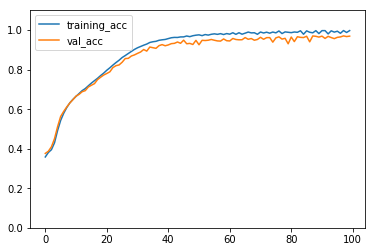

Testing...
Q 3245+0      T 3245   ☑ 3245  
Q 8312+52218  T 60530  ☑ 60530 
Q 52661+954   T 53615  ☑ 53615 
Q 5809+217    T 6026   ☑ 6026  
Q 2663+794    T 3457   ☑ 3457  
Q 1525+96574  T 98099  ☑ 98099 
Q 6+5856      T 5862   ☑ 5862  
Q 24+996      T 1020   ☑ 1020  
Q 32+583      T 615    ☑ 615   
Q 71043+67257 T 138300 ☑ 138300

Test Accuracy on 40000 test data:  0.9738791672229767


In [7]:
chars = '0123456789+ '
ctable = CharacterTable(chars)

digits = 5
epochs = 100
layer = 2
hidden_size = 128
batch_size = 128
train_size = 60000

train_x, train_y, val_x, val_y, test_x, test_y = generate_addition_data(train_size=train_size,
                                                                        digits=digits,
                                                                        ctable=ctable,
                                                                        chars=chars)
model = train_add_model(train_x=train_x,
                        train_y=train_y,
                        val_x=val_x,
                        val_y=val_y,
                        digits=digits,
                        hidden_size=hidden_size,
                        batch_size=batch_size,
                        layer=layer,
                        epoch=epochs,
                        chars = chars,
                        save_model=True)

model_tester(model=model,
             test_x=test_x,
             test_y=test_y,
             ctable=ctable)

del model

## 3. Subtractor

### Data Generator

In [8]:
def generate_subtraction_data(train_size, digits, ctable, chars):
    
    data_size = train_size + 2000 + 40000
    maxlen = digits + 1 + digits
    questions = []
    expected = []
    seen = set()
    print('Generating data...')
    while len(questions) < data_size:
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, digits + 1))))
        a, b = f(), f()
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)
        big = max(a,b)
        small = min(a,b)
        q = '{}-{}'.format(big, small)
        query = q + ' ' * (maxlen - len(q))
        ans = str(big - small)
        ans += ' ' * (digits - len(ans))
        questions.append(query)
        expected.append(ans)

    print('Total addition questions:', len(questions))
    print('Example questions:')
    print(questions[:5], expected[:5])

    print()
    
    x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(expected), digits, len(chars)), dtype=np.bool)
    for i, sentence in enumerate(questions):
        x[i] = ctable.encode(sentence, maxlen)
    for i, sentence in enumerate(expected):
        y[i] = ctable.encode(sentence, digits)

    indices = np.arange(len(y))
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]

    # train_test_split
    train_x = x[:-42000]
    train_y = y[:-42000]
    val_x = x[-42000:-40000]
    val_y = y[-42000:-40000]
    test_x = x[-40000:]
    test_y = y[-40000:]
    

    print('Training Data:')
    print(train_x.shape)
    print(train_y.shape)

    print('Validation Data:')
    print(val_x.shape)
    print(val_y.shape)

    print('Testing Data:')
    print(test_x.shape)
    print(test_y.shape)
    
    print()
    
    return train_x, train_y, val_x, val_y, test_x, test_y

### Model Trainer

In [9]:
def train_sub_model(train_x, train_y, val_x, val_y, digits, hidden_size, batch_size, layer, epoch, chars, save_model=False):
    
    print('Build model...')

    model = Sequential()
    model.add(layers.LSTM(hidden_size, input_shape=(2*digits + 1, len(chars))))
    model.add(layers.RepeatVector(digits))
    for _ in range(layer):
        model.add(layers.LSTM(hidden_size, return_sequences=True))

    model.add(layers.TimeDistributed(layers.Dense(len(chars))))
    model.add(layers.Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()

    history = model.fit(train_x, train_y,
                  batch_size=batch_size,
                  epochs=epoch,
                  validation_data=(val_x, val_y),
                  verbose=False
                  )
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['training_acc', 'val_acc'])
    plt.ylim(0, 1.1)
    plt.show()
    
    train_size = len(train_x)
    model_name = str(digits)+'_digits_sub_'+str(epoch)+'_epochs_'+str(train_size)+'_train_'+str(layer)+'_layers'
    
    if save_model:
        model.save('./models/'+model_name+'.h5')
        
    return model

### Training and Testing

Generating data...
Total addition questions: 102000
Example questions:
['8-7      ', '9800-466 ', '2814-193 ', '8615-1   ', '235-5    '] ['1   ', '9334', '2621', '8614', '230 ']

Training Data:
(60000, 9, 12)
(60000, 4, 12)
Validation Data:
(2000, 9, 12)
(2000, 4, 12)
Testing Data:
(40000, 9, 12)
(40000, 4, 12)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 12)             1548      
_________________________________________________________________
activation_

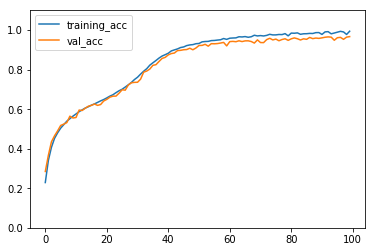

Testing...
Q 703-278   T 425  ☑ 425 
Q 9440-5925 T 3515 ☑ 3515
Q 3943-14   T 3929 ☑ 3929
Q 9986-4    T 9982 ☑ 9982
Q 1693-7    T 1686 ☑ 1686
Q 4077-28   T 4049 ☑ 4049
Q 6950-783  T 6167 ☑ 6167
Q 235-193   T 42   ☑ 42  
Q 955-338   T 617  ☑ 617 
Q 12-6      T 6    ☑ 6   

Test Accuracy on 40000 test data:  0.966125


In [10]:
chars = '0123456789- '
ctable = CharacterTable(chars)

digits = 4
epochs = 100
layer = 1
hidden_size = 128
batch_size = 128
train_size = 60000

train_x, train_y, val_x, val_y, test_x, test_y = generate_subtraction_data(train_size=train_size,
                                                                        digits=digits,
                                                                        ctable=ctable,
                                                                        chars=chars)
model = train_sub_model(train_x=train_x,
                        train_y=train_y,
                        val_x=val_x,
                        val_y=val_y,
                        digits=digits,
                        hidden_size=hidden_size,
                        batch_size=batch_size,
                        layer=layer,
                        epoch=epochs,
                        chars = chars,
                        save_model=True)

model_tester(model=model,
             test_x=test_x,
             test_y=test_y,
             ctable=ctable)

del model

## 4. Adder and Subtractor Combined

### Data Generator

In [11]:
def generate_add_sub_data(train_size, digits, ctable, chars):
    
    data_size = train_size + 2000 + 40000
    maxlen = digits + 1 + digits
    questions = []
    expected = []
    seen = set()
    count = 0
    print('Generating data...')
    while len(questions) < data_size:
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, digits + 1))))
        a, b = f(), f()
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)
        
        if count < data_size/2:
            q = '{}+{}'.format(a, b)
            query = q + ' ' * (maxlen - len(q))
            ans = str(a + b)
            ans += ' ' * (digits + 1 - len(ans))
        else:
            big = max(a,b)
            small = min(a,b)
            q = '{}-{}'.format(big, small)
            query = q + ' ' * (maxlen - len(q))
            ans = str(big - small)
            ans += ' ' * (digits + 1 - len(ans))
        questions.append(query)
        expected.append(ans)
        count += 1

    print('Total combined questions:', len(questions))
    print('Example questions:')
    print(questions[:5], expected[:5])
    print(questions[-5:], expected[-5:])
    
    print()

    x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(expected), digits + 1, len(chars)), dtype=np.bool)
    for i, sentence in enumerate(questions):
        x[i] = ctable.encode(sentence, maxlen)
    for i, sentence in enumerate(expected):
        y[i] = ctable.encode(sentence, digits + 1)

    indices = np.arange(len(y))
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]

    # train_test_split
    train_x = x[:-42000]
    train_y = y[:-42000]
    val_x = x[-42000:-40000]
    val_y = y[-42000:-40000]
    test_x = x[-40000:]
    test_y = y[-40000:]
    

    print('Training Data:')
    print(train_x.shape)
    print(train_y.shape)

    print('Validation Data:')
    print(val_x.shape)
    print(val_y.shape)

    print('Testing Data:')
    print(test_x.shape)
    print(test_y.shape)
    
    print()
    
    return train_x, train_y, val_x, val_y, test_x, test_y

### Model Trainer

In [12]:
def train_comb_model(train_x, train_y, val_x, val_y, digits, hidden_size, batch_size, layer, epoch, chars, save_model=False):
    
    print('Build model...')

    model = Sequential()
    model.add(layers.LSTM(hidden_size, input_shape=(2*digits + 1, len(chars))))
    model.add(layers.RepeatVector(digits + 1))
    for _ in range(layer):
        model.add(layers.LSTM(hidden_size, return_sequences=True))

    model.add(layers.TimeDistributed(layers.Dense(len(chars))))
    model.add(layers.Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()

    history = model.fit(train_x, train_y,
                  batch_size=batch_size,
                  epochs=epoch,
                  validation_data=(val_x, val_y),
                  verbose=False
                  )
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['training_acc', 'val_acc'])
    plt.ylim(0, 1.1)
    plt.show()
    
    train_size = len(train_x)
    model_name = str(digits)+'_digits_comb_'+str(epoch)+'_epochs_'+str(train_size)+'_train_'+str(layer)+'_layers'
    
    if save_model:
        model.save('./models/'+model_name+'.h5')
        
    return model

### Training and Testing

Generating data...
Total combined questions: 142000
Example questions:
['21+35761   ', '4663+1615  ', '7+78807    ', '3769+62    ', '15710+7595 '] ['35782 ', '6278  ', '78814 ', '3831  ', '23305 ']
['16175-7120 ', '675-354    ', '9224-200   ', '5632-2233  ', '2976-2     '] ['9055  ', '321   ', '9024  ', '3399  ', '2974  ']

Training Data:
(100000, 11, 13)
(100000, 6, 13)
Validation Data:
(2000, 11, 13)
(2000, 6, 13)
Testing Data:
(40000, 11, 13)
(40000, 6, 13)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 256)               276480    
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 6, 256)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 6, 256)            525312    
_________________________________________________________

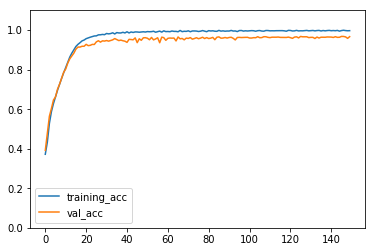

Testing...
Q 1297+2      T 1299   ☒ 1309  
Q 23272+806   T 24078  ☑ 24078 
Q 1868+427    T 2295   ☑ 2295  
Q 81358+870   T 82228  ☑ 82228 
Q 52487-2201  T 50286  ☑ 50286 
Q 8317-581    T 7736   ☑ 7736  
Q 568+97      T 665    ☑ 665   
Q 7633-2541   T 5092   ☑ 5092  
Q 5588+222    T 5810   ☑ 5810  
Q 28+92907    T 92935  ☑ 92935 

Test Accuracy on 40000 test data:  0.969787499666214


In [14]:
chars = '0123456789+- '
ctable = CharacterTable(chars)

digits = 5
epochs = 150
layer = 2
hidden_size = 256
batch_size = 128
train_size = 100000

train_x, train_y, val_x, val_y, test_x, test_y = generate_add_sub_data(train_size=train_size,
                                                                        digits=digits,
                                                                        ctable=ctable,
                                                                        chars=chars)
model = train_comb_model(train_x=train_x,
                        train_y=train_y,
                        val_x=val_x,
                        val_y=val_y,
                        digits=digits,
                        hidden_size=hidden_size,
                        batch_size=batch_size,
                        layer=layer,
                        epoch=epochs,
                        chars = chars,
                        save_model=True)

model_tester(model=model,
             test_x=test_x,
             test_y=test_y,
             ctable=ctable)

del model